#### @Author: Abhishek Kuriyal
#### @Contact: abhishek19@iiserb.ac.in

In [2]:
# Importing necessary modules

import os
import glob
import trimesh
import warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import pandas as pd

warnings.filterwarnings('ignore')

tf.random.set_seed(1234)

In [3]:
!nvidia-smi

Thu Mar 24 12:23:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   48C    P0    76W / 250W |  11981MiB / 40960MiB |     46%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset Preparation

In [32]:
# DATA_PATH = "/DATA/geo-data/Instance"

# TARGET = DATA_PATH + "/Human"

DATA_PATH = "/DATA/geo-data/Instance"

TARGET = DATA_PATH + "/Human"

subDir = glob.glob(TARGET + "/[!Human][!Child]*")

# female = glob.glob(subDir[0] + "/*")
# child = glob.glob(subDir[1] + "/*")
# human = glob.glob(subDir[2] + "/*")
# male = glob.glob(subDir[3] + "/*")

In [33]:
'''
Reading point clouds from provided csv files.
'''

def read_pc(px_dir, index):
    df = pd.read_csv(px_dir[index])
    
    try:
        X = df["//X"]
        
        Y = df["Y"]
        
        Z = df["Z"]
        
        I = df["Scalar field"]
        
        return np.array(X), np.array(Y), np.array(Z), np.array(I)
        
    except:
        pass
    
    
    try:
        X = df["//X"]
        
        Y = df["Y"]
        
        Z = df["Z"]
        
        R = df["R"]
        
        G = df["G"]
        
        B = df["B"]
        
        I = (R + G + B)//3
        
        return np.array(X), np.array(Y), np.array(Z), np.array(I)
    
    except:
        pass
    
    
    try:
        X = df["//X"]

        Y = df["Y"]

        Z = df["Z"]
        
        I = df["Intensity"]
        
        return np.array(X), np.array(Y), np.array(Z), np.array(I)
        
    except:
        pass
    
    
    
    try:
        X = df["x"]

        Y = df["y"]

        Z = df["z"]

        I = df["Intensity"]
        
        return np.array(X), np.array(Y), np.array(Z), np.array(I)

    except:
        pass

        
    X_np = np.array(X)
    Y_np = np.array(Y)
    Z_np = np.array(Z)
    I_np = np.array(I)
    
    return X_np, Y_np, Z_np, I_np

In [34]:
'''
Transformation functions, this will handle all the transformations (rotation, translation etc.)
'''

def translate(coord):
    X, Y, Z, I = coord
    
    m_X = int(np.mean(X))
    m_Y = int(np.mean(Y))
    m_Z = int(np.mean(Z))
    
    return (X - m_X, Y - m_Y, Z - m_Z, I)


def create_intensity_channel(coord):
    X, Y, Z = coord
    
    I = np.ones(len(coord))
    
    return (X, Y, Z, I)

In [35]:
def parse_dataset(NUM_POINTS=1000):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    ratio = 8.6/10
#     folders = glob.glob(DATA_PATH + TARGET + "/[!human][!child]")
    
    folders = subDir
    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        # gather all files
        
        folder_files = glob.glob(folder + "/*")
        
        f_len = len(folder_files)
        
        train_size = int(ratio*f_len)
        
        train_indices = np.random.choice(range(f_len), train_size, replace=False)

        test_indices = np.delete(range(f_len), train_indices)
        
        for index in train_indices:
            X, Y, Z, I = read_pc(folder_files, index)
            
            X, Y, Z, I = translate((X, Y, Z, I))
            
            X = np.expand_dims(X, axis=-1)
            Y = np.expand_dims(Y, axis=-1)
            Z = np.expand_dims(Z, axis=-1)
            I = np.expand_dims(I, axis=-1)
            
            coord = np.concatenate((X, Y, Z, I), axis=-1)
            
            if coord.shape[0] >= NUM_POINTS:
                idx = np.random.choice(coord.shape[0], 1000)
                coord = coord[idx]
                train_points.append(coord)
                train_labels.append(i)
                
            
            
        for index in test_indices:
            X, Y, Z, I = read_pc(folder_files, index)
            
            X, Y, Z, I = translate((X, Y, Z, I))
            
            X = np.expand_dims(X, axis=-1)
            Y = np.expand_dims(Y, axis=-1)
            Z = np.expand_dims(Z, axis=-1)
            I = np.expand_dims(I, axis=-1)
            
            coord = np.concatenate((X, Y, Z, I), axis=-1)
            
            if coord.shape[0] >= NUM_POINTS:
                idx = np.random.choice(coord.shape[0], 1000, replace=False)
                coord = coord[idx]
                test_points.append(coord)
                test_labels.append(i)
    
    
    train_points = np.array(train_points)
    test_points = np.array(test_points)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    
    return train_points, train_labels, test_points, test_labels, class_map

In [36]:
NUM_POINTS = 1000
NUM_CLASSES = 2

train_points, train_labels, test_points, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: Female
processing class: Male


In [38]:
train_points.shape, train_labels.shape, test_points.shape, test_labels.shape, CLASS_MAP

((50, 1000, 4), (50,), (8, 1000, 4), (8,), {0: 'Female', 1: 'Male'})

In [39]:
BATCH_SIZE = 8

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))


train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

2022-03-24 12:32:33.592399: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 12:32:34.403336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 26260 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


In [40]:
!nvidia-smi

Thu Mar 24 12:32:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   47C    P0    86W / 250W |  38819MiB / 40960MiB |     51%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Custom Layers and Regularizers

In [41]:
# Orthogonal Regularizer

class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [42]:
# Custom Layers


class Kappa(tf.keras.layers.Layer):
    def __init__(self, gamma=1):
        super(Kappa, self).__init__()
        self.gamma = gamma
        
    def call(self, inputs):
        self.inputs = inputs
        
        out = get_edge_feature()(inputs)
        
        out = tf.reduce_max(out, axis=2)
        
        out = layers.Conv1D(32, kernel_size=1, padding='valid', activation='relu')(out)
    
        out = layers.BatchNormalization(momentum=0.0)(out)

        out = layers.Conv1D(64, kernel_size=1, padding='valid', activation='relu')(out)

        out = layers.BatchNormalization(momentum=0.0)(out)
        
        out = layers.GlobalMaxPool1D()(out)
        
        kappa_mask = layers.Dense(
            self.inputs.shape[1], activation='softmax'
        )(out)
        
        return kappa_mask

class get_edge_feature(tf.keras.layers.Layer):
    def __init__(self):
        super(get_edge_feature, self).__init__()
        
        
    def adj_matrix(self, f_pc):   
        """Create adj_matrix by computing l2 norm between features.
          Args:
            Feature_point_cloud: tensor (batch_size, num_points, num_dims)
          Returns:
        adj_matrix: (batch_size, num_points, num_points)
        """
        batch_size = f_pc.shape[0]
        f_pc = tf.squeeze(f_pc)
        if batch_size == 1:
            f_pc = tf.expand_dims(f_pc, 0)

        f_pc_T = tf.transpose(f_pc, perm=[0, 2, 1])
        f_pc_inner = tf.matmul(f_pc, f_pc_T)
        f_pc_inner = -2*f_pc_inner
        f_pc_square = tf.reduce_sum(tf.square(f_pc), axis=-1, keepdims=True)
        f_pc_square_T = tf.transpose(f_pc_square, perm=[0, 2, 1])
        
        return f_pc_square + f_pc_inner + f_pc_square_T


    def KNN(self, adj_matrix, k=20):
        """Perform KNN on feature adjacency matrix.
      Args:
        Adjacency matrix: (batch_size, num_points, num_points)
        k: int
      Returns:
        KNN: (batch_size, num_points, k)
          """
        neg_adj = -adj_matrix
        _, knn_idx = tf.nn.top_k(neg_adj, k=k)
        return knn_idx
    
    def get_edge_op(self, f_pc, knn_idx, k=20):
        """Op to compute edge feature based on underlying features.
      Args:
        Feature point cloud: (batch_size, num_points, num_dims)
        knn_idx: (batch_size, num_points, k)
        k: int
      Returns:
        Edge specific features: (batch_size, num_points, k, num_dims)
        """
        batch_size = f_pc.shape[0]
        f_pc = tf.squeeze(f_pc)
        if batch_size == 1:
            f_pc = tf.expand_dims(f_pc, 0)

        f_pc_central = f_pc

        f_pc_shape = f_pc.shape
        batch_size = f_pc_shape[0]
        num_points = f_pc_shape[1]
        num_dims = f_pc_shape[2]
            
        idx_ = tf.range(batch_size) * num_points
        idx_ = tf.reshape(idx_, [batch_size, 1, 1]) 
        
        
        f_pc_flat = tf.reshape(f_pc, [-1, num_dims])
        
        f_pc_neighbors = tf.gather(f_pc_flat, knn_idx+idx_)
        
        f_pc_central = tf.expand_dims(f_pc_central, axis=-2)
        
        f_pc_central = tf.tile(f_pc_central, [1, 1, k, 1])
        
        l1_distance = f_pc_neighbors - f_pc_central

        edge_feature = tf.concat([f_pc_central, l1_distance], axis=-1)
        
        return edge_feature

    def call(self, x):
        adj = self.adj_matrix(x)   # Shape
        
        knn_idx = self.KNN(adj)
        
        edge_feature = self.get_edge_op(x, knn_idx)
        
        return edge_feature
    
    
class KNN_Downsampler(tf.keras.layers.Layer):
    '''
    Uses MLP to approximate a Downsampler by convolving over edge features.
    The Downsampler calculates an importance weight mask thus assigning contribution score 
    towards final prediction for each point.
    '''
    
    def __init__(self, num_points, reduce_num=1024):
        super(KNN_Downsampler, self).__init__()
        self.num_points = num_points
        self.reduce_num = reduce_num
        self.bias = keras.initializers.Constant(np.eye(num_points).flatten())
        self.reg = OrthogonalRegularizer(num_points)
        
        
    def ds_op(self, weight_mask):
        idx = tf.argsort(weight_mask, axis=1, direction='DESCENDING')

        multidim = tf.gather(self.inputs, idx, axis=1)

        ds_points = tf.stack(
            [multidim[i, i, :self.reduce_num, :] for i in tf.range(self.inputs.shape[0])], axis=0
        )

        return ds_points
     
    
    def call(self, inputs):
        self.inputs = inputs
        
        out = get_edge_feature()(inputs)
        
        out = tf.reduce_max(out, axis=2)
        
        out = layers.Conv1D(32, kernel_size=1, padding='valid', activation='relu')(out)
    
        out = layers.BatchNormalization(momentum=0.0)(out)

        out = layers.Conv1D(64, kernel_size=1, padding='valid', activation='relu')(out)

        out = layers.BatchNormalization(momentum=0.0)(out)

        out = layers.Conv1D(512, kernel_size=1, padding='valid', activation='relu')(out)

        out = layers.BatchNormalization(momentum=0.0)(out)

        out = layers.GlobalMaxPool1D()(out)
        
        weight_mask = layers.Dense(
            self.num_points, activation='softmax'
        )(out)
        
        ds_points = self.ds_op(weight_mask)
        
        return ds_points
    
    
        
    
class affine_net(tf.keras.layers.Layer):
    '''
    An mlp based transformer for converting input point cloud to similar canonical shape.
    '''
    def __init__(self, num_features):
        self.num_features = num_features
        self.bias = keras.initializers.Constant(np.eye(num_features).flatten())
        self.reg = OrthogonalRegularizer(num_features)
        super(affine_net, self).__init__()

    
    def call(self, inputs):
        out = layers.Conv1D(32, kernel_size=1, padding='valid')(inputs)
        
        out = layers.BatchNormalization(momentum=0.0)(out)
        
        out = layers.Conv1D(64, kernel_size=1, padding='valid')(out)
    
        out = layers.BatchNormalization(momentum=0.0)(out)
        
        out = layers.Conv1D(512, kernel_size=1, padding='valid')(out)
        
        out = layers.BatchNormalization(momentum=0.0)(out)
        
        out = layers.GlobalMaxPooling1D()(out)
        
        out = layers.Dense(256)(out)
        
        out = layers.BatchNormalization(momentum=0.0)(out)
        
        out = layers.Dense(128)(out)
        
        out = layers.BatchNormalization(momentum=0.0)(out)
        
        out = layers.Dense(
            self.num_features*self.num_features, kernel_initializer='zeros', bias_initializer=self.bias, activity_regularizer=self.reg,
        )(out)
        
        affine_feat = layers.Reshape((self.num_features, self.num_features))(out)
        
        return layers.Dot(axes=(2,1))([inputs, affine_feat])        
        
    

## Model Definition

In [43]:
'''
DMS-DGCNN : Acronynm for Differential Multi-Spectral DGCNN
'''

class DMS_DGCNN(tf.keras.Model):
    def __init__(self, NUM_CHANNELS):
        super(DMS_DGCNN, self).__init__()
        self.kappa_mask = Kappa(gamma=1)
        self.transformer = affine_net(num_features=4)
        self.downsampler = KNN_Downsampler(num_points=1000, reduce_num=1000)
        self.conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=0.0)
        self.conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization(momentum=0.0)
        self.conv3 = tf.keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu')
        self.bn3 = tf.keras.layers.BatchNormalization(momentum=0.0)
        self.conv4 = tf.keras.layers.Conv1D(filters=256, kernel_size=1, activation='relu')
        self.bn4 = tf.keras.layers.BatchNormalization(momentum=0.0)
        self.conv5 = tf.keras.layers.Conv1D(filters=1024, kernel_size=1, activation='relu')
        self.pool1 = tf.keras.layers.GlobalMaxPooling1D()
        self.pool2 = tf.keras.layers.GlobalAveragePooling1D()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.bn5 = tf.keras.layers.BatchNormalization(momentum=0.0)
        self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.bn6 = tf.keras.layers.BatchNormalization(momentum=0.0)
        self.dense3 = tf.keras.layers.Dense(NUM_CHANNELS, activation='softmax')
        self.getFeature = get_edge_feature()
        
    def kappa_op(self, inputs, K):
        inputs_S = inputs[:, :, :3]
        
        inputs_I = inputs[:, :, -1]
        
        inputs_I = tf.expand_dims(inputs_I, axis=-1)
        
        K = tf.expand_dims(K, axis=-1)
        
        out = tf.concat((inputs_S, inputs_I*K), axis=-1)
        
        return out
        
    def call(self, inputs):
        K = self.kappa_mask(inputs)
        
        inputs = self.kappa_op(inputs, K)
        
        inputs_T = self.transformer(inputs)
        
        ds_inputs = self.downsampler(inputs_T)
        
        edge_feature = self.getFeature(ds_inputs)
        
        out = self.conv1(edge_feature)

        out = self.bn1(out)

        feature1 = tf.reduce_max(out, axis=2)

        edge_feature = self.getFeature(feature1)
        
        out = self.conv2(edge_feature)

        out = self.bn2(out)

        feature2 = tf.reduce_max(out, axis=2)

        edge_feature = self.getFeature(feature2)

        out = self.conv3(edge_feature)

        out = self.bn3(out)

        feature3 = tf.reduce_max(out, axis=2)

        edge_feature = self.getFeature(feature3)

        out = self.conv4(edge_feature)

        out = self.bn4(out)

        feature4 = tf.reduce_max(out, axis=2)

        features = tf.concat((feature1, feature2, feature3, feature4), axis=2)

        out = self.conv5(features)

        feature5 = self.pool1(out)
        
        feature6 = self.pool2(out)

        features = tf.concat((feature5, feature6), 1)

        out = self.dense1(features)

        out = self.bn5(out)

        out = self.dense2(out)

        out = self.bn6(out)

        out = self.dense3(out)

        outputs = out

        return outputs

## Helper functions and Classes

In [44]:
def loss(model, x, y, training):
    y_ = model(x, training=training)
    
    return loss_object(y_true=y, y_pred=y_)


def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


def visualize(model, test_dataset):
    data = test_dataset.take(1)

    points, labels = list(data)[0]
    points = points[:8, ...]
    labels = labels[:8, ...]

    # run test data through model
    preds = model(points)
    preds = tf.math.argmax(preds, -1)

    points = points.numpy()

    # plot points with predicted class and label
    fig = plt.figure(figsize=(15, 10))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, projection="3d")
        ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2], c=points[i, :, 3])
        ax.set_title(
            "prediction: {:}, true: {:}".format(
                CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
            )
        )
        ax.set_axis_off()
    plt.show()

    
# Color maps 
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Training and Evaluation function

In [45]:
def train(model, num_epochs=20):
    train_loss_results = []
    train_accuracy_results = []

    val_loss_results = []
    val_accuracy_results = []

    for epoch in range(num_epochs):
        # Start Training
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        # Training loop - using batch of 32
        cnt = 0
        print("-----------------------------------------------------------")
        print(color.BOLD + f"Epoch {epoch}" + color.END)
        for x, y in train_dataset:
            # Optimize the model
            cnt += 1
            print(f"Training batch data... {cnt}/{len(train_dataset)}", end='\r')
            loss_value, grads = grad(model, x, y)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Track progress

            epoch_loss_avg.update_state(loss_value)

            epoch_accuracy.update_state(y, model(x, training=True))


        # Append Train Loss and Accuracy
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

        print("\nTraining Loss: {:.3f}, Training SparseCategoricalAccuracy: {:.3%}".format(
        epoch_loss_avg.result(), epoch_accuracy.result()
        ))
        
        # Start Validation
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
        cnt = 0
        for x, y in test_dataset:
            cnt += 1
            print(f"Validating batch data... {cnt}/{len(test_dataset)}", end='\r')
            loss_value = loss(model, x, y, training=False)
            
            # Track Progress
            
            epoch_loss_avg.update_state(loss_value)
            
            epoch_accuracy.update_state(y, model(x, training=False))
            
        # Append Validation Loss and Accuracy
        val_loss_results.append(epoch_loss_avg.result())
        val_accuracy_results.append(epoch_accuracy.result())

        print("\nValidation Loss: {:.3f}, Validation SparseCategoricalAccuracy: {:.3%}".format(
        epoch_loss_avg.result(), epoch_accuracy.result()
        ))
        
    return train_loss_results, train_accuracy_results, val_loss_results, val_accuracy_results

In [46]:
# Evaluation on test dataset

def evaluate(model, test_dataset):
    loss_avg = tf.keras.metrics.Mean()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
    cnt = 0
    for x, y in test_dataset:
        cnt += 1
        print(f"Validating batch data... {cnt}/{len(test_dataset)}", end='\r')
        loss_value = loss(model, x, y, training=False)

        # Track Progress

        loss_avg.update_state(loss_value)

        accuracy.update_state(y, model(x, training=False))

    print("\Evaluation Loss: {:.3f}, Evaluation SparseCategoricalAccuracy: {:.3%}".format(
    loss_avg.result(), accuracy.result()
    ))
    
    return None

## Training Walkthrough

In [56]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

device = 'gpu' if len(physical_devices) else 'cpu'

with tf.device(device):
    model = DMS_DGCNN(NUM_CHANNELS=2)

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

    train_loss_results, train_accuracy_results, val_loss_results, val_accuracy_results = train(model)

-----------------------------------------------------------
Epoch 0
Training batch data... 7/7
Training Loss: 1.316, Training SparseCategoricalAccuracy: 60.000%
Validating batch data... 1/1
Validation Loss: 21.945, Validation SparseCategoricalAccuracy: 62.500%
-----------------------------------------------------------
Epoch 1
Training batch data... 7/7
Training Loss: 0.996, Training SparseCategoricalAccuracy: 66.000%
Validating batch data... 1/1
Validation Loss: 12.468, Validation SparseCategoricalAccuracy: 50.000%
-----------------------------------------------------------
Epoch 2
Training batch data... 7/7
Training Loss: 0.851, Training SparseCategoricalAccuracy: 56.000%
Validating batch data... 1/1
Validation Loss: 40.317, Validation SparseCategoricalAccuracy: 62.500%
-----------------------------------------------------------
Epoch 3
Training batch data... 7/7
Training Loss: 0.801, Training SparseCategoricalAccuracy: 66.000%
Validating batch data... 1/1
Validation Loss: 17.457, Va

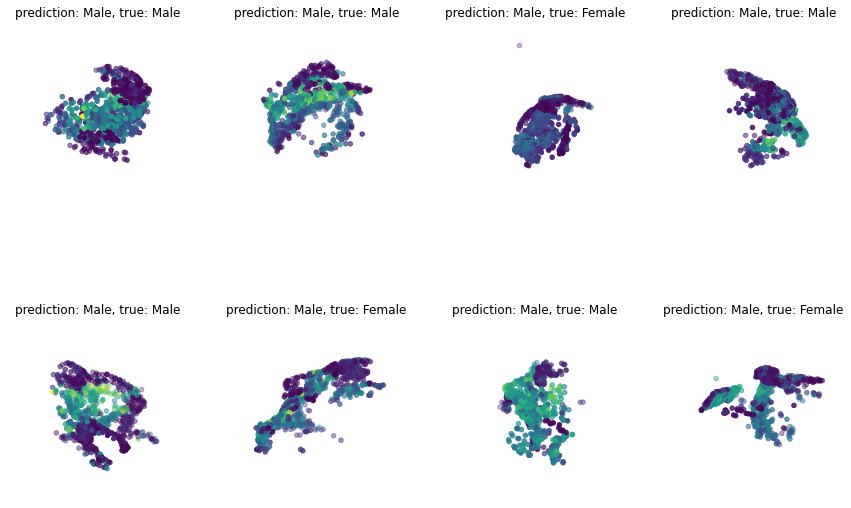

In [58]:
# Visual results for test dataset

visualize(model, test_dataset)